In [1]:
%reload_ext autoreload
%autoreload 2

# Jos haluaa saada keskellä koodia "pretty printin" niinkuin cellin lopussa
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_node_amount import *
from draw_cluster_route import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from klusterointi import *

ModuleNotFoundError: No module named 'draw_cluster_route'

In [7]:
df = database_query("SELECT * FROM DATA")
df

ajokerta  node_id           timestamp   x   y  grid_id   distance  \
0               2        1 2020-06-25 15:21:46  28  15      628   0.962081   
1               2        1 2020-06-25 15:21:47  28  15      628   1.028834   
2               2        1 2020-06-25 15:21:47  28  15      628   0.648460   
3               2        1 2020-06-25 15:21:47  28  15      628   0.826075   
4               2        1 2020-06-25 15:21:50  26  15      626   1.753767   
...           ...      ...                 ...  ..  ..      ...        ...   
2761246      8956       31 2020-09-22 14:41:04  19  16      659   0.608769   
2761247      8956       31 2020-09-22 14:41:05  19  16      659   0.743303   
2761248      8956       31 2020-09-22 14:41:06  18  16      658   0.594138   
2761249      8956       31 2020-09-22 14:41:11   1  28     1121  28.712454   
2761250      8956       31 2020-09-22 14:41:11   0  25     1000   4.095852   

            kesto  dayofweek  current_hour  
0        6812.007          3             8  
1        6812.007          3             8  
2        6812.007          3             8  
3        6812.007          3             8  
4        6812.007          3             8  
...           ...        ...           ...  
2761246    97.531          1             7  
2761247    97.531          1             7  
2761248    97.531          1             7  
2761249    97.531          1             7  
2761250    97.531          1             7  

[2761251 rows x 10 columns]

In [ ]:
distances = df.groupby(['ajokerta'])['distance'].sum().to_dict()
df["distance"] = df['ajokerta'].map(distances)

In [8]:
%%time
df = df_to_features(df)

CPU times: user 59.7 s, sys: 7.39 ms, total: 59.7 s
Wall time: 59.8 s


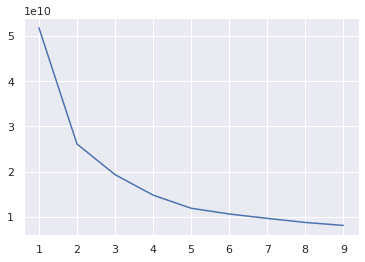

In [9]:
ideal_k(df)

# Haetaan toisesta tietokannasta hyvät reitit

In [2]:
df = database_query("SELECT * FROM REITIT")
df

ajokerta  node_id           timestamp  grid_x  grid_y  grid_id  \
0            2        1 2020-06-25 15:21:46      28      15      628   
1            2        1 2020-06-25 15:21:47      28      15      628   
2            2        1 2020-06-25 15:21:47      27      15      627   
3            2        1 2020-06-25 15:21:47      27      15      627   
4            2        1 2020-06-25 15:21:50      26      15      626   
...        ...      ...                 ...     ...     ...      ...   
8330        32        1 2020-07-03 17:58:28       3      35     1403   
8331        32        1 2020-07-03 17:58:29       3      35     1403   
8332        32        1 2020-07-03 17:58:29       3      35     1403   
8333        32        1 2020-07-03 17:58:30       3      35     1403   
8334        32        1 2020-07-03 17:58:32       2      35     1402   

      distance     kesto  dayofweek  current_hour     x     y  
0     0.962081  6812.007          3             8  2876    21  
1     1.028834  6812.007          3             8  2832   114  
2     0.648460  6812.007          3             8  2770   133  
3     0.826075  6812.007          3             8  2760    51  
4     1.753767  6812.007          3             8  2601   125  
...        ...       ...        ...           ...   ...   ...  
8330  0.280000   708.000          4            10   100  2516  
8331  0.158114   708.000          4            10   105  2501  
8332  0.100000   708.000          4            10    99  2493  
8333  0.127279   708.000          4            10    90  2484  
8334  0.186011   708.000          4            10    79  2469  

[8335 rows x 12 columns]

# Muutetaan piirrematriisiksi

In [3]:
df2 = df_to_features(df)
df2

NameError: name 'df_to_features' is not defined

# Klusteroidaan reitit, niin että päivä korreloisi reitin keston kanssa

In [13]:
from sklearn.cluster import AgglomerativeClustering
#df2 = df_reitit[['x', 'y']].sample(n=10000, random_state=1)

potato = df2[['ajokerta','dayofweek','kesto']]
#potato = df2.copy()#df2.iloc[:,5:-1]
#potato['ajokerta'] = df2['ajokerta']

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_kmeans = cluster.fit_predict(potato)

potato["predicted"] = y_kmeans

ajot = df2["ajokerta"].unique()
oltava =  potato.index.unique()

poistettavat = set(ajot)-set(oltava)

data = potato[~potato['ajokerta'].isin(poistettavat)]
#print(data["ajokerta"].unique())
data["pred"] = None

zip_iterator = zip(oltava, y_kmeans)
parit = dict(zip_iterator)

df_pred = df.copy()
df_pred['pred'] = df_pred["ajokerta"].map(parit).fillna(data["pred"])
df_pred['predicted'] = df_pred["ajokerta"].map(parit).fillna(data["predicted"])
#df_pred[['x','y']] = df[['x','y']]
data['pred'] = data["ajokerta"].map(parit).fillna(data["pred"])
#data[['x','y']] = df[['x','y']]
data

ajokerta  dayofweek     kesto  predicted  pred
0          2          3  6812.007          3     1
1          3          3  1440.522          2     0
2          4          3   771.016          1     1
3          5          3   265.000          0     1
4          7          4   660.002          1     0
5          8          4   877.001          1     1
6         10          6   107.002          0     0
7         11          6   210.998          0     2
8         13          0   636.001          1     1
9         14          0  1729.000          2     0
10        15          0   479.002          0     0
11        16          0  1323.999          2     0
12        17          0   459.998          0     0
13        18          0   974.998          1     4
14        19          1   580.999          0     0
15        21          1   529.000          0     2
16        22          1   577.998          0     0
17        23          2   415.000          0     1
18        24          2  5128.998          4     1

# Tiputetaan ajokerrat, jotka ei klusteroituneet

In [18]:
df_pred = df_pred.dropna()
df_pred

ajokerta  node_id           timestamp  grid_x  grid_y  grid_id  \
1            2        1 2020-06-25 15:21:47      28      15      628   
2            2        1 2020-06-25 15:21:47      27      15      627   
3            2        1 2020-06-25 15:21:47      27      15      627   
4            2        1 2020-06-25 15:21:50      26      15      626   
5            2        1 2020-06-25 15:21:50      25      15      625   
...        ...      ...                 ...     ...     ...      ...   
6416        24        1 2020-07-01 16:14:16      14      16      654   
6417        24        1 2020-07-01 16:14:27      14      16      654   
6418        24        1 2020-07-01 16:14:54      14      16      654   
6419        24        1 2020-07-01 16:14:55      14      16      654   
6420        24        1 2020-07-01 16:15:07      14      16      654   

      distance     kesto  dayofweek  current_hour     x    y  check  pred  \
1     1.028834  6812.007          3             8  2832  114    2.0   1.0   
2     0.648460  6812.007          3             8  2770  133    2.0   1.0   
3     0.826075  6812.007          3             8  2760   51    2.0   1.0   
4     1.753767  6812.007          3             8  2601  125    2.0   1.0   
5     0.310644  6812.007          3             8  2570  127    2.0   1.0   
...        ...       ...        ...           ...   ...  ...    ...   ...   
6416  0.070711  5128.998          2             9  1372  193   24.0   1.0   
6417  0.111803  5128.998          2             9  1367  183   24.0   1.0   
6418  0.142127  5128.998          2             9  1358  172   24.0   1.0   
6419  0.056569  5128.998          2             9  1354  168   24.0   1.0   
6420  0.257099  5128.998          2             9  1360  148   24.0   1.0   

      predicted  
1           1.0  
2           1.0  
3           1.0  
4           1.0  
5           1.0  
...         ...  
6416        1.0  
6417        1.0  
6418        1.0  
6419        1.0  
6420        1.0  

[6420 rows x 15 columns]

# Piirretään klusterit
## Legendissä näkyy ajokerrat, jotka löytyvät klusterista

In [17]:
draw_cluster_route(df_pred, 'predicted', 'ajokerta')

[1. 0. 2. 4.]
Ajokerrat:  4


In [34]:
import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

def draw_cluster(df, column):
    ajot = df[column].unique()
    ajot_len = max(df[column].unique())

    print("Ajokerrat: ",ajot_len)
    
    Cols = 6

    Rows = ajot_len // Cols 
    Rows += ajot_len % Cols
    
    Position = range(1,ajot_len + 1)
    
    plt.figure(figsize=(20,10),facecolor=(1, 1, 1))
        
    #cluster.fit_predict(df)
    #plt.figure(figsize=(10, 7))
    #plt.title("Agglomerative Clustering")
    #plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster.labels_, cmap='rainbow')

    #plt.rcParams['figure.facecolor'] = 'white'
    #fig.patch.set_facecolor('black')
    for i,k in zip(ajot,range(ajot_len)):
        df_temp = df[df[column] == i][['x', 'y']]
        cluster.fit_predict(df_temp)
        #plt.subplot((ajot_len/5)+1,6,i+1)
        plt.subplot(Rows,Cols,Position[k])
        plt.scatter(df_temp.iloc[:,0], df_temp.iloc[:,1], c=cluster.labels_, cmap='rainbow')
        #plt.plot(df[df["ajokerta"] == i]['x'], df[df["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
        #plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
        #plt.scatter(out_x, out_y, color='green', marker='s', s=2)
        plt.title(f"Reitti {i+1}")
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        #plt.xlim(0, 40)
        #plt.ylim=(0, 40)
        #plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
draw_cluster(df_pred,'ajokerta')

Ajokerrat:  24


# Dendogrammi
Dendrogrammi havainnollistaa, kuinka kukin klusteri koostuu piirtämällä U-muotoinen linkki ei-yksittäisen klusterin ja sen lasten välille. 

- U-lenkin yläosa osoittaa klusterin sulautumisen.
- U-lenkin kaksi osaa osoittavat, mitkä klusterit yhdistettiin. 
- U-lenkin kahden haaran pituus edustaa lapsiklustereiden välistä etäisyyttä. 
    - Se on myös kofeneettinen etäisyys kahden lapsiryhmän alkuperäisten havaintojen välillä.

In [42]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

# generate the linkage matrix
#X = df_pred[['ajokerta', 'dayofweek', 'kesto']].values
X = df2[['distance', 'current_hour']]
#X = df2
Z = linkage(X,
            method='complete',  # dissimilarity metric: max distance across all pairs of 
                                # records between two clusters
            metric='euclidean'
    )                           # you can peek into the Z matrix to see how clusters are 
                                # merged at each iteration of the algorithm

# calculate full dendrogram and visualize it
'''plt.figure(figsize=(30, 10))
dendrogram(Z)
plt.show()'''

'''# retrive clusters with `max_d`
from scipy.cluster.hierarchy import fcluster
max_d = 25       # I assume that your `Latitude` and `Longitude` columns are both in 
                 # units of miles
clusters = fcluster(Z, max_d, criterion='distance')'''

plt.figure(figsize=(30, 10))
dn = hierarchy.dendrogram(Z)

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                           orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1],
                           above_threshold_color='#bcbddc',
                           orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

'plt.figure(figsize=(30, 10))\ndendrogram(Z)\nplt.show()'

"# retrive clusters with `max_d`\nfrom scipy.cluster.hierarchy import fcluster\nmax_d = 25       # I assume that your `Latitude` and `Longitude` columns are both in \n                 # units of miles\nclusters = fcluster(Z, max_d, criterion='distance')"

<Figure size 2160x720 with 0 Axes>